# Email Classification

We will use fast.ai to build an email ham/spam classifier.

# Load data

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA607/main/Project4/EMAILSpamCollectionFull.csv')

In [2]:
df.head()

,id,from,subject,category,text
0,1,robert elz <kre@munnari.oz.au>,re: new sequences window,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,ham,Klez: The Virus That Won't Die Already the mo...
4,5,tony nugent <tony@linuxworks.com.au>,re: insert signature,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."


In [3]:
df.describe(include='object')

,from,subject,category,text
count,7933,7903,9350,7953
unique,2388,3491,2,4618
top,boingboing <rssfeeds@example.com>,[spambayes] test sets?,ham,
freq,114,58,5553,84


# Cleanup Data

Drop NAs.

In [4]:
df1 = df.dropna()
df1.isna().sum()

id          0
from        0
subject     0
category    0
text        0
dtype: int64

Remove **id** and **email_src** columns.

In [5]:
df1 = df1[['from', 'subject', 'text', 'category']]
df1.head()

,from,subject,text,category
0,robert elz <kre@munnari.oz.au>,re: new sequences window,"Date: Wed, 21 Aug 2002 10:54:46 -0...",ham
1,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,"Martin A posted:Tassos Papadopoulos, the Gree...",ham
2,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,Man Threatens Explosion In Moscow Thursday Au...,ham
3,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,Klez: The Virus That Won't Die Already the mo...,ham
4,tony nugent <tony@linuxworks.com.au>,re: insert signature,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro...",ham


Strip HTML tags.

In [6]:
df1['subject'] = df1['subject'].replace('<[^<>]*>', " ", regex=True)
df1['text'] = df1['text'].replace('<[^<>]*>', " ", regex=True)
df1.head()

<ipython-input-6-ae6e46cfc607>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['subject'] = df1['subject'].replace('<[^<>]*>', " ", regex=True)


,from,subject,text,category
0,robert elz <kre@munnari.oz.au>,re: new sequences window,"Date: Wed, 21 Aug 2002 10:54:46 -0...",ham
1,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,"Martin A posted:Tassos Papadopoulos, the Gree...",ham
2,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,Man Threatens Explosion In Moscow Thursday Au...,ham
3,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,Klez: The Virus That Won't Die Already the mo...,ham
4,tony nugent <tony@linuxworks.com.au>,re: insert signature,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro...",ham


Look at data summary.

In [7]:
df1.describe(include='object')

,from,subject,text,category
count,7902,7902,7902,7902
unique,2366,3490,4553,2
top,boingboing <rssfeeds@example.com>,[spambayes] test sets?,,ham
freq,114,58,48,5549


## Compute NULL model (baseline) accuracy

Compute baseline accuracy: any model worth considering must have greater accuracy (at a minimum) than null model. 

This data set is unbalanced (more ham instances than spams), null model has 70% accuracy.

In [8]:
cat_size = df1.groupby('category').size()
print(cat_size)

ham_prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , ham_prop)

category
ham     5549
spam    2353
dtype: int64
Baseline (null model) accuracy:  0.70222728423184


## Prepare DataBlock

In [9]:
from fastai.data.all import *
from fastai.text.all import *

Create data loaders for classification, build **DataBlock** using **TextBlock** and **CategoryBlock**. Set aside 20% data using **TrainTestSplitter** for model testing.

In [10]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('subject', 'text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('category'),
            splitter=TrainTestSplitter(test_size=0.2,stratify=df1.category)
        ).dataloaders(df1)

In [11]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos xxfld 1 = ? iso-2022 - xxunk xxfld 2 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk -",ham
1,"xxbos xxfld 1 re : sed / s / united states / roman empire / g xxfld 2 "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct . xxmaj perhaps the most fundamental thing to realize about >",ham
2,"xxbos xxfld 1 sed / s / united states / roman empire / g xxfld 2 > a world where some live in comfort and plenty , while half of the human > race lives on less than $ 2 a day , is neither just nor xxunk correct . xxmaj perhaps the most fundamental thing to realize about life on xxmaj earth xxunk following is a fascinating document of official xxmaj government policy that bears close reading . xxmaj it is the aspirations of a wonderful nation in an imperfect world . > xxmaj the war on terrorism is not a clash of civilizations . xxmaj it does , > however , reveal the clash inside a civilization , a battle for the > future of the xxmaj muslim world . xxmaj this is a struggle of ideas and this is an > area where xxmaj america must xxunk",ham
3,"xxbos xxfld 1 your membership community & commentary , 06 - 29 - 01 xxfld 2 xxrep 3 - xxunk - type : text / plain ; charset = iso-8859 - 1your xxmaj membership xxmaj community & xxmaj commentary ( june 29 , 2001)it 's xxmaj all xxmaj about xxmaj making moneyinformation to provide you with the absolute best low and no cost ways of providing traffic to your site , helping you to capitalize on the power and potential the web brings to every net - preneur . xxrep 3 - xxmaj this xxmaj issue xxmaj contains xxmaj sites xxmaj who xxmaj will xxmaj trade xxmaj links xxmaj with xxmaj you ! xxrep 3 - xxrep 13 - xxup in xxup this xxup issue xxrep 13 - 32 xxmaj easy xxmaj ways xxmaj to xxmaj breath xxmaj new xxmaj life xxmaj into xxmaj any xxunk xxunk xxmaj you xxmaj",spam
4,"xxbos xxfld 1 make thousands just sending emails . it 's easy . xxfld 2 xxmaj from : xxunk xxrep 5 s xxunk : \t\t\t\t\t xxmaj subject : xxmaj earn money sending e - mails . xxmaj it 's easy ! \t▁ xxup new xxup improved xxunk friend , you can earn a lot of money in the next 90 days sending xxunk impossible ? xxmaj is there a catch ? xxup no , there is no catch ; justsend your e - mails and be on your way to financial freedom . xxmaj basically , i send out as many of these e - mails as i can , xxunk send me cash in the mail for information that i just e - xxunk to them . xxmaj everyday , i make a three minute drive to my xxup p.o . xxmaj xxunk that there are at least a",spam


## Create Learner and fine-tune (transformer)

In [12]:
learner = text_classifier_learner(dls_cls, 
                                    AWD_LSTM, 
                                    drop_mult=0.5, 
                                    metrics=[accuracy, Precision(), Recall(), F1Score()])

SuggestedLRs(valley=0.0002290867705596611)

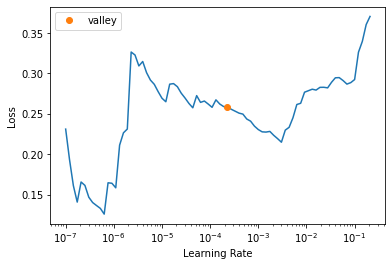

In [14]:
learner.lr_find()

In [15]:
learner.fine_tune(3, 0.0002290867705596611)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.210932,0.153988,0.946869,0.892495,0.934183,0.912863,01:06


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.194021,0.128350,0.949399,0.929670,0.898089,0.913607,02:06
1,0.183050,0.127815,0.956989,0.912065,0.946921,0.929167,02:04
2,0.164885,0.118465,0.951929,0.937916,0.898089,0.917570,02:04


## Interpret results

F1-score of 0.91+ is good and so are precision/recall. Note - the model was tuned using GPUs, tuning on CPUs will take significantly longer (hours).

Show a few predictions on training data.

In [16]:
learner.show_results()

,text,category,category_
0,"xxbos xxfld 1 xxunk & enenkio xxunk americans shame ! xxfld 2 xxmaj reply xxmaj from xxunk following message was recieved xxmaj saturday , 13 xxmaj july xxunk has been xxunk or changed . i hold no xxunk for xxunk of this xxunk : enenkio truth ( xxunk : xxmaj sat , 13 xxmaj jul 2002 xxunk xxunk : enenkio@webtv.net ( robert xxunk : xxunk truth ( xxunk xxmaj news xxmaj archives xxunk xxup news xxup releases xxup and xxunk 28 , 1 xxrep 3 9 : xxmaj replies to xxmaj asia xxunk 22 , 1 xxrep 3 9 : xxmaj news xxmaj release - xxmaj gold xxunk 4 , 1 xxrep 3 9 : xxmaj replies to xxmaj published articlesjune 3 , 1 xxrep 3 9 : xxmaj replies to xxmaj published articlesjune 2 , 1 xxrep 3 9 : xxmaj replies to xxmaj published articlesjune 1 , 1",spam,spam
1,"xxbos xxfld 1 tribute moviemail - vol . 1 # 48 xxfld 2 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 4 0 _ 01c24a39.4307a140content - type : text / plain ; \t charset=""iso-8859 - 1""content - transfer - encoding : quoted - printable \t▁\t▁ = 09 \t▁\t = 20 \t▁\t▁ = 09=20 \t▁ = 09 = 09 = xxunk xxmaj player xxmaj please click on the image to play the trailer . = 20 \t = 20=09 = 09 = 09 \t▁\t▁ = 09 = 09 \t▁ xxmaj go out and see a movie tonight ! \t▁\t = 20 = 09 = 09=20 \t = 20 = 09 = 09 = 09 = 09 \t▁\t▁ = 09 = 09 \t▁ xxup enter xxup for xxup your xxup chance xxup to xxup win",ham,spam
2,"xxbos xxfld 1 core java technologies tech tips , september 10 , 2002 ( arraylist vs. linkedlist , zero - length arrays ) xxfld 2 xxmaj core xxmaj java xxmaj technologies xxmaj technical xxmaj tips xxup code { color : # xxrep 6 3 ; font - family : xxmaj verdana , xxmaj courier , xxmaj monospace ; font - size : 10pt}pre { color : # xxrep 6 3 ; font - family : xxmaj verdana , xxmaj courier , xxmaj monospace ; font - size : 10pt}body , div , span { color : # xxrep 6 3 ; font - family : xxmaj arial , xxmaj helvetica , sans - serif ; font - size : 10pt}td , th { color : # xxrep 6 3 ; font - family : xxmaj arial , xxmaj helvetica , sans - serif ; font - size : 10pt}tr {",ham,ham
3,"xxbos xxfld 1 winxpnews : time to patch your windows media player xxfld 2 winxpnews ™ a : link { color : # xxunk ; font - weight : bold;}a : visited { color : # xxunk ; font - weight : bold;}a : active { color : # ff xxrep 4 0 ; font - weight : bold;}a : hover { color : # ff xxrep 4 0 ; font - weight : bold ; } winxpnews ™ e - zine xxmaj tue , xxmaj jul 9 , 2002 ( vol . 2 , 27 - xxmaj issue 33 ) xxmaj feel free to forward this newsletter to other winxp enthusiasts . xxmaj read this newsletter online here : http : / / xxrep 3 w .winxpnews.com / ? xxunk xxmaj for a quick unsubscribe ( gasp ! ) click here : http : / / xxrep 3 w",ham,ham
4,"xxbos xxfld 1 market ca n't find its bottom with both hands xxfld 2 xxmaj this is a multi - part message in xxup mime format … xxrep 12 - = _ 1033478774 - 12610 - 4content - type : text / plain ; charset=""iso-8859 - 1""content - disposition : inlinecontent - transfer - encoding : 7bitto view this newsletter in full - color , visit : http : / / newsletter.mediaunspun.com / index xxrep 4 0 21074.cfmmedia unspunwhat the xxmaj press is xxmaj reporting and xxmaj why ( xxrep 3 w .mediaunspun.com ) xxrep 65 - xxmaj october 1 , 2002 xxrep 65 - xxup in xxup this xxup issue xxrep 65 - * xxup market xxup ca n't xxup find xxup its xxup bottom xxup with xxup both xxup hands * xxup winnick : xxup hands - off xxup or xxup red - handed ? * xxup other",ham,ham
5,"xxbos xxfld 1 bush covers the waterfront xxfld 2 xxmaj this is a multi - part message in xxup mime format … xxrep 12 - = _ 1034083278 - 26594 - 4content - type : text / plain ; charset=""iso-8859 - 1""content - disposition : inlinecontent - transfer - encoding : 7bitto view this newsletter in full - color : http : / / newsletter.mediaunspun.com / index xxrep 4 0 xxunk unspunwhat the xxmaj press is xxmaj reporting and xxmaj why ( xxrep 3 w .mediaunspun.com ) xxrep 65 - xxmaj october

Plot confusion matrix. Note, the matrix is generated using the test data set (20% of data data).

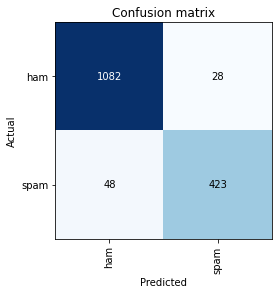

In [17]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Saving and loading model

In [18]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [19]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

Create data loader for language modeling. Set aside 10% data using **RandomSplitter** for model validation.

In [20]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(text_cols=('from', 'subject', 'text'), 
                             is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(valid_pct=0.1, seed=12345)
    ).dataloaders(df1, bs=64)

Create data loader

In [21]:
dls_lm.show_batch(max_n = 10)

,text,text_
0,xxbos xxfld 1 bugzilla-daemon@hughes-family.org xxfld 2 [ sadev ] [ bug xxrep 3 7 ] tests to find hand - written html xxfld 3 http : / / xxrep 3 w .hughes - family.org / bugzilla / xxunk xxrep 3 7 xxrep 7 - xxmaj additional xxmaj comments xxmaj from xxunk 2002 - 08 - 28 xxunk xxrep 7 - 3 . usage of just like ( ie . without ) which,xxfld 1 bugzilla-daemon@hughes-family.org xxfld 2 [ sadev ] [ bug xxrep 3 7 ] tests to find hand - written html xxfld 3 http : / / xxrep 3 w .hughes - family.org / bugzilla / xxunk xxrep 3 7 xxrep 7 - xxmaj additional xxmaj comments xxmaj from xxunk 2002 - 08 - 28 xxunk xxrep 7 - 3 . usage of just like ( ie . without ) which is
1,"/ wealthnowwe are looking for energetic and self motivated people . xxmaj if that is youthan click on the link and fill out the form , and one of ouremployement specialist will contact you.to be removed from our link simple go to : http : / / xxrep 3 w .basetel.com / xxunk - xxunk - xxunk - xxunk xxbos xxfld 1 peter peltonen < pisara@iki.fi > xxfld 2 re : http","wealthnowwe are looking for energetic and self motivated people . xxmaj if that is youthan click on the link and fill out the form , and one of ouremployement specialist will contact you.to be removed from our link simple go to : http : / / xxrep 3 w .basetel.com / xxunk - xxunk - xxunk - xxunk xxbos xxfld 1 peter peltonen < pisara@iki.fi > xxfld 2 re : http :"
2,": / / lists.sourceforge.net / lists / listinfo / spamassassin - talk xxbos xxfld 1 "" cnet news.com investor "" < online # xxunk > xxfld 2 news.com investor : techs slump with intel xxfld 3 xxup cnet xxmaj investor xxmaj dispatch xxmaj quote xxmaj lookup xxmaj enter symbol : · xxmaj symbol xxmaj lookup xxmaj quotes delayed 20 + minutes • xxmaj my xxmaj portfolio • xxmaj broker xxmaj reports •","/ / lists.sourceforge.net / lists / listinfo / spamassassin - talk xxbos xxfld 1 "" cnet news.com investor "" < online # xxunk > xxfld 2 news.com investor : techs slump with intel xxfld 3 xxup cnet xxmaj investor xxmaj dispatch xxmaj quote xxmaj lookup xxmaj enter symbol : · xxmaj symbol xxmaj lookup xxmaj quotes delayed 20 + minutes • xxmaj my xxmaj portfolio • xxmaj broker xxmaj reports • ipos"
3,"xxup considering xxup my xxup presentcircumstance xxup and xxup situation.i xxup escaped xxup along xxup with xxup my xxup husband xxup and xxup two xxup of xxup our xxup sonsgeorge xxup kongolo xxup and xxup basher xxup out xxup of xxup democratic xxup republic xxup ofcongo ( drc ) xxup to xxup abidjan , xxup cote xxup d'ivoire xxup where xxup my xxup familyand i xxup settled , xxup while xxup we","considering xxup my xxup presentcircumstance xxup and xxup situation.i xxup escaped xxup along xxup with xxup my xxup husband xxup and xxup two xxup of xxup our xxup sonsgeorge xxup kongolo xxup and xxup basher xxup out xxup of xxup democratic xxup republic xxup ofcongo ( drc ) xxup to xxup abidjan , xxup cote xxup d'ivoire xxup where xxup my xxup familyand i xxup settled , xxup while xxup we xxup"
4,", xxmaj finance & & xxmaj trade xxmaj commission of xxmaj france ( ubi xxmaj france ) , & xxunk xxmaj industries xxmaj association , xxmaj india , & xxmaj global xxup vsat forum , uk , & xxmaj international xxmaj broadcasting xxmaj convention ( xxunk ) , xxup uk , & xxmaj national xxmaj association xxunk ( xxunk ) , xxup usa , & xxmaj swiss xxmaj multimedia association , switzerland","xxmaj finance & & xxmaj trade xxmaj commission of xxmaj france ( ubi xxmaj france ) , & xxunk xxmaj industries xxmaj association , xxmaj india , & xxmaj global xxup vsat forum , uk , & xxmaj international xxmaj broadcasting xxmaj convention ( xxunk ) , xxup uk , & xxmaj national xxmaj association xxunk ( xxunk ) , xxup usa , & xxmaj swiss xxmaj multimedia association , switzerland ,"
5,") { = / / v3.0=0d var xxunk ; if(d.images ) { if(!d.mm_p ) xxunk = xxunk var i , xxunk , xxunk ; = xxunk ; i < xxunk ; xxunk if ( xxunk ( "" # "" ) ! = 3d0 ) { = xxunk xxmaj image ; xxunk = mm_swapimgr

Create text classifier learner. Use accuracy, and Perplexity for metrics.

In [22]:
lm_learner = language_model_learner(
            dls_lm, 
            AWD_LSTM, 
            wd=0.1,
            metrics=[accuracy, Perplexity()]).to_fp16()

Fine-tune language model.

In [23]:
lm_learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.952452,3.555752,0.384222,35.014141,03:32


Save language model state.

In [24]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Unfreeze model for futher tuning.

In [25]:
lm_learner.unfreeze()

In [26]:
lm_learner.fit_one_cycle(3, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.961155,4.025864,0.348689,56.028675,03:43
1,3.396685,3.381052,0.415862,29.401699,03:44
2,2.858337,2.932356,0.477898,18.771803,03:45


Save fully tuned model.

In [27]:
lm_learner.save_encoder('finetuned')

Text generation

In [28]:
TEXT = "Let us show you how to win the sweepstakes"
N_WORDS = 40
N_SENTENCES = 2
preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75)
for _ in range(N_SENTENCES)]
print("\n".join(preds))

Let us show you how to win the sweepstakes for free free shipping ! xxfld 3 This is a multi - part message in MIME format . ------ ====== ______ nextpartnextpartnextpartnextpartnextpartnextpart ______ 333333 000000 ______ c16f3_01c260c3.2978b160contentc16f3_01c260c3.2978b160contentc16f3_01c260c3.2978b160contentc16f3_01c260c3.2978b160contentc16f3_01c260c3.2978b160contentc16f3_01c260c3.2978b160content ------ typetypetypetypetypetype :::::: texttexttexttexttexttext ////// plainplainplainplainplainplain ;;;;;; 						
Let us show you how to win the sweepstakes for free promotion - discount free xxfld 3 Dear Friend , To be removed from these mailing list simply reply to this email with REMOVE in the subject line . xxfld 1 matthias saou <


Create DataLoaders for classification.

In [29]:
dls_cls = DataBlock(
            blocks=(TextBlock.from_df(text_cols=('from', 'subject', 'text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
            CategoryBlock),
            get_x=ColReader('text'),
            get_y=ColReader('category'), 
            splitter=RandomSplitter(valid_pct=0.2, seed=12345)
            ).dataloaders(df1, bs=64)

In [30]:
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos xxfld 1 "" = ? iso-2022 - xxunk "" < hito@opentext.com > xxfld 2 = ? iso-2022 - xxunk xxfld 3 xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk",ham
1,"xxbos xxfld 1 "" mr . fork "" < fork_list@hotmail.com > xxfld 2 re : sed / s / united states / roman empire / g xxfld 3 "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct .",ham
2,xxbos xxfld 1 ike < bearike@sohu.com > xxfld 2 = ? xxunk = f2 = d4 = xxunk xxfld 3 xxmaj this is a multi - part message in xxup mime format -- xxunk - xxunk - b6fa-0050ba415022content - type : text / plain ; charset = gb2312content - transfer - encoding : quoted - printable = cb = c4 = b4 = f3 = cb = d8 = d6 = ca = c5 = e0 = d1 = f8 = b4 = f2 = d4 = xxunk xxup mba = bd = cc = d3 = fd = b5 = c4 = cc = d8 = b5 = e3 = a3 = ac = d4 = da = cb = d8 = d6 = ca = c5 = e0 = d1 = f8 = xxunk = d7 = dc = ca = c7 = d2 = d4 = d3,spam


Create text classification learner.

In [31]:
learn = text_classifier_learner(dls_cls, 
                                AWD_LSTM, 
                                drop_mult=0.5, 
                                metrics=[accuracy, Precision(), Recall()])

In [32]:
learn = learn.load_encoder('finetuned')

In [33]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.110893,0.068952,0.981646,0.948515,0.993776,01:07


In [34]:
learn.freeze_to(-2)

In [35]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.064825,0.036837,0.985443,0.963636,0.989627,01:14


In [36]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.037355,0.023880,0.989241,0.971602,0.993776,01:45


In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.020518,0.021145,0.991772,0.979550,0.993776,02:09
1,0.023145,0.019531,0.991772,0.987526,0.985477,02:08


Plot confusion matrix.

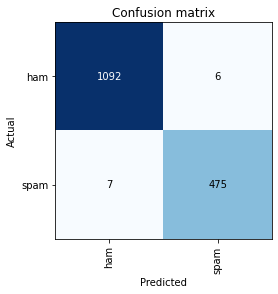

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()